In [1]:
import pandas as pd
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
import matplotlib.pyplot as plt
import cv2
import os
from torch.utils.data import DataLoader, Dataset

In [ ]:
@article{He2015,
	author = {Kaiming He and Xiangyu Zhang and Shaoqing Ren and Jian Sun},
	title = {Deep Residual Learning for Image Recognition},
	journal = {arXiv preprint arXiv:1512.03385},
	year = {2015}
}

### Data Loader

In [2]:
# data loader
class whale_dolphin(Dataset):
    def __init__(self, root, train=True):
        train_imgs = []
        val_imgs = []
        for path in os.listdir(root):
            label = int(path[:1])
            path_lst = path.split(".")
            if int(path_lst[0][2:]) < 1301:
                train_imgs.append((os.path.join(root, path), label))
            else:
                val_imgs.append((os.path.join(root, path), label))
        self.imgs = train_imgs if train else val_imgs
        self.transforms = transforms.Compose([
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, index):
        img_path = self.imgs[index][0]
        img_label = self.imgs[index][1]
        img_data = Image.open(img_path)
        img_data = self.transforms(img_data)
        return img_data, img_label


# This this the data loader for test set
class whale_dolphin_test(Dataset):
    def __init__(self, root):
        self.imgs = []
        for path in os.listdir(root):
            label = int(path[:1])
            path_lst = path.split(".")
            self.imgs.append((os.path.join(root, path), label))
        self.transforms = transforms.Compose([
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, index):
        img_path = self.imgs[index][0]
        img_label = self.imgs[index][1]
        img_data = Image.open(img_path)
        img_data = self.transforms(img_data)
        return img_data, img_label


In [3]:
root = 'dataset/train'
train_dataset = whale_dolphin(root, train=True)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
for data, label in train_dataloader:
    print(data.shape)
    print(len(label))
    break

torch.Size([64, 3, 128, 128])
64


## ResNet 50 Model

In [4]:
class BottleNeck(nn.Module):
    """
    BottleNeck block for the ResNet-50
    1x1, 3x3, 1x1 Three convolution layers
    """
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        super().__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)  # Does not change size
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride,
                               padding=1)  # if stride=2，half size of the input, if =1, don't change
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, padding=0)  # 不改变尺寸
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        # identity shortcut
        x = x + identity
        x = self.relu(x)

        return x

In [5]:
class ResNet50(nn.Module):
    def __init__(self, bottleneck, layers, image_channels, class_nums):
        super().__init__()
        # initialize the in_channels after the first max pool layer
        self.in_channels = 64

        # conv1
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()

        # Res net bottleneck layers conv2, conv3, conv4, conv5
        # conv2
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = self._make_layer(bottleneck, layers[0], out_channels=64, stride=1)
        # conv3
        self.conv3 = self._make_layer(bottleneck, layers[1], out_channels=128, stride=2)
        # conv4
        self.conv4 = self._make_layer(bottleneck, layers[2], out_channels=256, stride=2)
        # conv5
        self.conv5 = self._make_layer(bottleneck, layers[3], out_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(2048, class_nums)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.maxpool(x)

        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)  # reshape the 4-d tensor to 2-d matrix
        x = self.fc(x)

        return x

    def _make_layer(self, bottleneck, block_nums, out_channels, stride):
        identity_downsample = None
        layers = []
        block_minus = 0
        if stride != 1 or self.in_channels != out_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * 4, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels * 4)
            )
            block_minus = 1
        layers.append(bottleneck(self.in_channels, out_channels, identity_downsample, stride=stride))
        self.in_channels = out_channels * 4

        for i in range(block_nums - block_minus):
            layers.append(bottleneck(self.in_channels, out_channels))

        return nn.Sequential(*layers)


## Train

In [7]:
def train():
    # 1.load dataset
    root = 'dataset/train'
    batch_size = 64
    train_data = whale_dolphin(root, train=True)
    val_data = whale_dolphin(root, train=False)
    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

    # 2.load model
    num_classes = 2
    img_channels = 3
    model = ResNet50(BottleNeck, [3, 4, 6, 3], img_channels, num_classes)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cup')
    model = model.to(device)

    # 3.prepare hyperparameters
    criterion = nn.CrossEntropyLoss()
    learning_rate = 1e-4
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    epochs = 20

    # 4.train
    val_acc_list = []
    out_dir = "results/"
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}")
        model.train()
        sum_loss = 0.0
        correct = 0.0
        total = 0.0
        for batch_idx, (images, labels) in enumerate(train_dataloader):
            length = len(train_dataloader)
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)  # torch.size([batch_size, num_class])
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            sum_loss += loss.item()
            _, predicted = torch.max(outputs.data, dim=1)
            total += labels.size(0)
            correct += predicted.eq(labels.data).cpu().sum()
            print('[epoch:%d, iter:%d] Loss: %.03f | Acc: %.3f%% '
                  % (epoch + 1, (batch_idx + 1 + epoch * length), sum_loss / (batch_idx + 1), 100. * correct / total))

        print("Waiting Val...")
        with torch.no_grad():
            correct = 0.0
            total = 0.0
            for batch_idx, (images, labels) in enumerate(val_dataloader):
                model.eval()
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, dim=1)
                total += labels.size(0)
                correct += (predicted == labels).sum()

            print('Val\'s ac is: %.3f%%' % (100 * correct / total))

            acc_val = 100. * correct / total
            val_acc_list.append(acc_val)

        torch.save(model.state_dict(), out_dir + "res-last.pt")
        if acc_val == max(val_acc_list):
            torch.save(model.state_dict(), out_dir + "res-best.pt")
            print(f"save epoch {epoch} model")


train()


Epoch 1
[epoch:1, iter:1] Loss: 0.898 | Acc: 46.875% 
[epoch:1, iter:2] Loss: 1.148 | Acc: 50.781% 
[epoch:1, iter:3] Loss: 0.967 | Acc: 57.292% 
[epoch:1, iter:4] Loss: 0.853 | Acc: 62.500% 
[epoch:1, iter:5] Loss: 0.802 | Acc: 62.812% 
[epoch:1, iter:6] Loss: 0.787 | Acc: 59.896% 
[epoch:1, iter:7] Loss: 0.773 | Acc: 60.045% 
[epoch:1, iter:8] Loss: 0.751 | Acc: 60.742% 
[epoch:1, iter:9] Loss: 0.727 | Acc: 62.153% 
[epoch:1, iter:10] Loss: 0.715 | Acc: 63.125% 
[epoch:1, iter:11] Loss: 0.701 | Acc: 63.636% 
[epoch:1, iter:12] Loss: 0.682 | Acc: 64.974% 
[epoch:1, iter:13] Loss: 0.674 | Acc: 66.226% 
[epoch:1, iter:14] Loss: 0.664 | Acc: 66.295% 
[epoch:1, iter:15] Loss: 0.657 | Acc: 66.562% 
[epoch:1, iter:16] Loss: 0.660 | Acc: 66.113% 
[epoch:1, iter:17] Loss: 0.649 | Acc: 66.912% 
[epoch:1, iter:18] Loss: 0.640 | Acc: 67.448% 
[epoch:1, iter:19] Loss: 0.629 | Acc: 67.928% 
[epoch:1, iter:20] Loss: 0.629 | Acc: 67.891% 
[epoch:1, iter:21] Loss: 0.624 | Acc: 68.304% 
[epoch:1, ite

[epoch:5, iter:169] Loss: 0.134 | Acc: 95.625% 
[epoch:5, iter:170] Loss: 0.123 | Acc: 96.354% 
[epoch:5, iter:171] Loss: 0.131 | Acc: 96.429% 
[epoch:5, iter:172] Loss: 0.136 | Acc: 95.898% 
[epoch:5, iter:173] Loss: 0.132 | Acc: 96.007% 
[epoch:5, iter:174] Loss: 0.123 | Acc: 96.250% 
[epoch:5, iter:175] Loss: 0.126 | Acc: 96.165% 
[epoch:5, iter:176] Loss: 0.132 | Acc: 95.964% 
[epoch:5, iter:177] Loss: 0.126 | Acc: 96.034% 
[epoch:5, iter:178] Loss: 0.128 | Acc: 95.871% 
[epoch:5, iter:179] Loss: 0.129 | Acc: 95.833% 
[epoch:5, iter:180] Loss: 0.141 | Acc: 95.312% 
[epoch:5, iter:181] Loss: 0.136 | Acc: 95.496% 
[epoch:5, iter:182] Loss: 0.133 | Acc: 95.660% 
[epoch:5, iter:183] Loss: 0.139 | Acc: 95.477% 
[epoch:5, iter:184] Loss: 0.148 | Acc: 95.078% 
[epoch:5, iter:185] Loss: 0.147 | Acc: 95.015% 
[epoch:5, iter:186] Loss: 0.153 | Acc: 94.815% 
[epoch:5, iter:187] Loss: 0.152 | Acc: 94.905% 
[epoch:5, iter:188] Loss: 0.150 | Acc: 94.987% 
[epoch:5, iter:189] Loss: 0.154 | Acc: 9

[epoch:9, iter:336] Loss: 0.093 | Acc: 96.484% 
[epoch:9, iter:337] Loss: 0.087 | Acc: 96.701% 
[epoch:9, iter:338] Loss: 0.083 | Acc: 96.875% 
[epoch:9, iter:339] Loss: 0.079 | Acc: 97.017% 
[epoch:9, iter:340] Loss: 0.077 | Acc: 97.135% 
[epoch:9, iter:341] Loss: 0.074 | Acc: 97.356% 
[epoch:9, iter:342] Loss: 0.075 | Acc: 97.210% 
[epoch:9, iter:343] Loss: 0.074 | Acc: 97.292% 
[epoch:9, iter:344] Loss: 0.074 | Acc: 97.363% 
[epoch:9, iter:345] Loss: 0.073 | Acc: 97.426% 
[epoch:9, iter:346] Loss: 0.070 | Acc: 97.569% 
[epoch:9, iter:347] Loss: 0.068 | Acc: 97.533% 
[epoch:9, iter:348] Loss: 0.067 | Acc: 97.578% 
[epoch:9, iter:349] Loss: 0.069 | Acc: 97.396% 
[epoch:9, iter:350] Loss: 0.067 | Acc: 97.514% 
[epoch:9, iter:351] Loss: 0.065 | Acc: 97.622% 
[epoch:9, iter:352] Loss: 0.065 | Acc: 97.591% 
[epoch:9, iter:353] Loss: 0.065 | Acc: 97.625% 
[epoch:9, iter:354] Loss: 0.065 | Acc: 97.656% 
[epoch:9, iter:355] Loss: 0.067 | Acc: 97.685% 
[epoch:9, iter:356] Loss: 0.076 | Acc: 9

[epoch:13, iter:500] Loss: 0.088 | Acc: 97.266% 
[epoch:13, iter:501] Loss: 0.093 | Acc: 97.222% 
[epoch:13, iter:502] Loss: 0.090 | Acc: 97.344% 
[epoch:13, iter:503] Loss: 0.090 | Acc: 97.159% 
[epoch:13, iter:504] Loss: 0.084 | Acc: 97.396% 
[epoch:13, iter:505] Loss: 0.078 | Acc: 97.596% 
[epoch:13, iter:506] Loss: 0.077 | Acc: 97.545% 
[epoch:13, iter:507] Loss: 0.080 | Acc: 97.292% 
[epoch:13, iter:508] Loss: 0.080 | Acc: 97.266% 
[epoch:13, iter:509] Loss: 0.077 | Acc: 97.426% 
[epoch:13, iter:510] Loss: 0.078 | Acc: 97.309% 
[epoch:13, iter:511] Loss: 0.080 | Acc: 97.368% 
[epoch:13, iter:512] Loss: 0.076 | Acc: 97.500% 
[epoch:13, iter:513] Loss: 0.075 | Acc: 97.545% 
[epoch:13, iter:514] Loss: 0.073 | Acc: 97.585% 
[epoch:13, iter:515] Loss: 0.074 | Acc: 97.554% 
[epoch:13, iter:516] Loss: 0.071 | Acc: 97.656% 
[epoch:13, iter:517] Loss: 0.070 | Acc: 97.688% 
[epoch:13, iter:518] Loss: 0.070 | Acc: 97.596% 
[epoch:13, iter:519] Loss: 0.067 | Acc: 97.685% 
[epoch:13, iter:520]

[epoch:17, iter:664] Loss: 0.037 | Acc: 99.023% 
[epoch:17, iter:665] Loss: 0.034 | Acc: 99.132% 
[epoch:17, iter:666] Loss: 0.037 | Acc: 99.062% 
[epoch:17, iter:667] Loss: 0.035 | Acc: 99.006% 
[epoch:17, iter:668] Loss: 0.033 | Acc: 99.089% 
[epoch:17, iter:669] Loss: 0.033 | Acc: 99.038% 
[epoch:17, iter:670] Loss: 0.034 | Acc: 98.884% 
[epoch:17, iter:671] Loss: 0.032 | Acc: 98.958% 
[epoch:17, iter:672] Loss: 0.031 | Acc: 98.926% 
[epoch:17, iter:673] Loss: 0.033 | Acc: 98.897% 
[epoch:17, iter:674] Loss: 0.033 | Acc: 98.872% 
[epoch:17, iter:675] Loss: 0.038 | Acc: 98.766% 
[epoch:17, iter:676] Loss: 0.045 | Acc: 98.672% 
[epoch:17, iter:677] Loss: 0.043 | Acc: 98.735% 
[epoch:17, iter:678] Loss: 0.043 | Acc: 98.651% 
[epoch:17, iter:679] Loss: 0.042 | Acc: 98.709% 
[epoch:17, iter:680] Loss: 0.041 | Acc: 98.698% 
[epoch:17, iter:681] Loss: 0.045 | Acc: 98.625% 
[epoch:17, iter:682] Loss: 0.044 | Acc: 98.678% 
[epoch:17, iter:683] Loss: 0.043 | Acc: 98.727% 
[epoch:17, iter:684]

## Load Model

In [8]:
model = ResNet50(BottleNeck, [3, 4, 6, 3], 3, 2)
model.load_state_dict(torch.load("results/res-best.pt"))
model = model.to('cuda')
model.eval()

ResNet50(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (0): BottleNeck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, aff

In [9]:
def predict(input, model):
  with torch.no_grad():
    out = model(input)
    _, pre = torch.max(out.data, 1)
    return pre.item()

In [10]:
transform = transforms.Compose([transforms.ToTensor()])
image = Image.open("dataset/train/0-100.jpg")
image = transform(image).reshape((1, 3, 128, 128)).to('cuda')
out = predict(image, model)
print(f"Prediction of the image is: {out}")


Prediction of the image is: 0


In [11]:
def test(model):
    # 1.load the model
    model = model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cup')
    model = model.to(device)
    model.eval()

    # 2.load the test data
    root = "dataset/test"
    batch_size = 64
    test_data = whale_dolphin_test(root)
    test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

    # 3.test
    print("Waiting Test...")
    with torch.no_grad():
        correct = 0
        total = 0
        for (images, labels) in test_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            out = model(images)
            _, pre = torch.max(out.data, 1)
            total += labels.size(0)   # why use (0) not [0]???
            correct += (pre == labels).sum().item()
        print(f"The Accuracy is: {correct/total}")


test(model)

Waiting Test...
The Accuracy is: 0.884


## Visualization

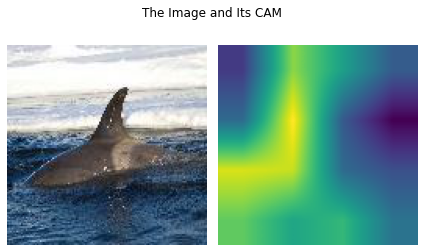

In [12]:
def return_CAM(model, image_path, transform):
    # transform the image
    image = Image.open(image_path)
    image = transform(image).reshape((1, 3, 128, 128)).to('cuda')
    # get the fc layer weights
    fc_weight = model.fc.weight.cpu().detach().numpy()
    # get the output feature from the last conv block
    features = []
    def hook(model, input, output):
        features.append(output.data.cpu().numpy())
    handle = model.conv5.register_forward_hook(hook)
    output = model(image)
    feature_conv = features[0]
    handle.remove()
    # get the shape
    bz, nc, h, w = feature_conv.shape
    # get the prediction of the image
    img_class = predict(image, model)
    # get the CAM
    cam = fc_weight[img_class].dot(feature_conv.reshape(nc, h*w))
    cam = cam.reshape(h, w)
    # normalize the CAM
    cam_img = (cam - cam.min()) / (cam.max() - cam.min())
    # change the pixel to 0-255
    cam_img = np.uint8(255 * cam_img)
    # resize the image
    out_cam = cv2.resize(cam_img, (128, 128))
    
    # Visualize the image and CAM
    img = Image.open(image_path)
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(img)
    ax[0].axis('off')
    ax[1].imshow(out_cam)
    ax[1].axis('off')
    plt.tight_layout()
    fig.suptitle('The Image and Its CAM')
    plt.show()
    

return_CAM(model, "dataset/train/1-233.jpg", transform)

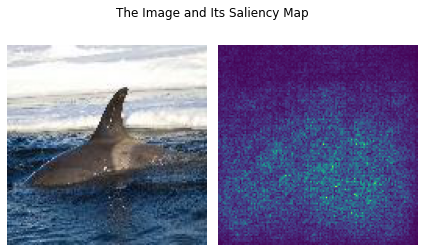

In [24]:
def saliency_map(image_path, transform, model):

    # preprocess the image
    transform = transforms.Compose([transforms.ToTensor()])
    image = Image.open(image_path)
    image = transform(image).reshape((1, 3, 128, 128)).to('cuda')

    # require gradient
    image.requires_grad_()

    # get the output
    output = model(image)
    output_idx = output.argmax()
    output_max = output[0, output_idx]

    # backpropagation to get the derivative of the output based on the image
    output_max.backward()

    # get the graident. Question: Add the .abs()???????
    # dimension: (batch_size, channel, width, height), get the max value along the channels
    saliency, _ = torch.max(image.grad.data.abs(), dim=1) 
    saliency = saliency.reshape(128, 128)

    # reshape the saliency vector to image
    image = image.reshape(-1, 128, 128)

    # visualization
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(image.cpu().detach().numpy().transpose(1, 2, 0))
    ax[0].axis('off')
    ax[1].imshow(saliency.cpu())
    ax[1].axis('off')
    plt.tight_layout()
    fig.suptitle('The Image and Its Saliency Map')
    plt.show()
saliency_map("dataset/train/1-233.jpg", transform, model)

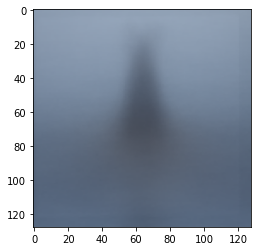

In [35]:
image1 = np.array(Image.open("dataset/train/1-233.jpg"))
image2 = np.array(Image.open("dataset/train/1-234.jpg"))
img_total = np.zeros(49152)
for i in range(1, 1501):
    img_total += np.array(Image.open(f"dataset/train/1-{i}.jpg")).flatten()
img_total = img_total / 1500
img_show = img_total.astype(int)
img_show = img_show.reshape((128, 128, 3))
plt.figure('Image')
plt.imshow(img_show)



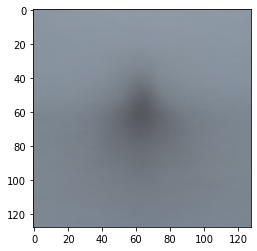

In [36]:
image1 = np.array(Image.open("dataset/train/1-233.jpg"))
image2 = np.array(Image.open("dataset/train/1-234.jpg"))
img_total = np.zeros(49152)
for i in range(1, 1501):
    img_total += np.array(Image.open(f"dataset/train/0-{i}.jpg")).flatten()
img_total = img_total / 1500
img_show = img_total.astype(int)
img_show = img_show.reshape((128, 128, 3))
plt.figure('Image')
plt.imshow(img_show)